In [1]:
import numpy as np
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time
from scipy.stats import rankdata

In [2]:
def lap_noise(data, epsilon, K, N, M):
    pri_data = data + np.random.laplace(loc = 0.0, scale = (K*(16*N-11)/N)/epsilon, size=data.shape)
    
    min = 10000
    
    for i in range(M):
        if pri_data[i] > 0 and pri_data[i] < min:
            min = pri_data[i]
    
    for i in range(M):
        if pri_data[i] < 0:
            pri_data[i] = min
    
    return pri_data

In [3]:
def total(n):
    h = n[1]+n[2]+n[3] + 2*(n[4]+n[5]+n[6]+n[7]+n[8]+n[9])
    i = n[3]+n[7]+n[8] + 2*n[9]
    j = n[2]+n[5] + 2*n[6] + n[8]
    
    if h == 0:
        return 0
    else:
        return (4*((i-h/4)**2) + 2*((i+j-h/2)**2) + 4*((j-h/4)**2))/h

In [4]:
def f(x, y, theta):
    t = (x - math.sqrt(2)*math.cos(theta))**2 + (y - math.sin(theta))**2
    return math.sqrt(t)

def eDistance(x,y):
    if x != 0:
        roots = np.roots([4, 4*y, 8*x*x + y*y -4, -4*y, -y*y])
        #print(roots)
        theta = np.zeros(9)
        theta[0] = 0
        c = 1
        for i in range(4):
            if roots[i] >= -1 and roots[i] <= 1:
                theta[c] = math.asin(roots[i])
                if theta[c] >= 0:
                    theta[c+1] = math.pi - theta[c]
                else:
                    theta[c+1] = - math.pi - theta[c]
                c += 2
        #print(theta)
        
        distance = 1000000000
        for j in range(c):
            #print(f(x,y,theta[j]))
            if f(x,y,theta[j]) < distance:
                distance = f(x,y,theta[j])
                
    else:
        if y > 0:
            distance = math.fabs(1-y)
        else:
            distance = math.fabs(-1-y)
    return distance

In [5]:
def appx_SHD_total(cc,n):
    h = n[1]+n[2]+n[3] + 2*(n[4]+n[5]+n[6]+n[7]+n[8]+n[9])
    i = n[3]+n[7]+n[8] + 2*n[9]
    j = n[2]+n[5] + 2*n[6] + n[8]
    T = total(n)
    
    if h <= cc:
        s = 2*(i-j)/cc
        t = 2*(i+j-cc/2)/cc
        d = eDistance(s,t)
        if T < cc:
            return -math.ceil((math.sqrt(2)-1)*(cc-h)/(2*math.sqrt(2)) + d*cc/8)
        else:
            return math.ceil((math.sqrt(2)-1)*(cc-h)/(2*math.sqrt(2)) + d*cc/8)-1
    else:
        s = 2*(i-j)/math.sqrt(h*cc)
        t = 2*(i+j-h/2)/math.sqrt(h*cc)
        d = eDistance(s,t)
        if T < cc:
            return -math.ceil(d*math.sqrt(h*cc)/8)
        else:
            return math.ceil(d*math.sqrt(h*cc)/8)-1

In [6]:
def random_num(pd):
    dist = np.cumsum(pd).tolist()
    dist[-1] = 1.0
    num = np.random.rand()
    dist.append(num)
    return sorted(dist).index(num)

def exp_mec(shd, m, K, epsilon):
    S = np.zeros(K)
    k = 0
    
    w = np.zeros(m)
    p = np.zeros(m)
    
    while k < K:
        sumw = 0
        for i in range(m):
            w[i] = math.exp(epsilon * shd[i] / (2*K))
            sumw += w[i]
        for i in range(m):
            p[i] = w[i]/sumw
        
        x = random_num(p)
        shd[x] = -1000000.0
        S[k] = x
        k += 1
    
    return S

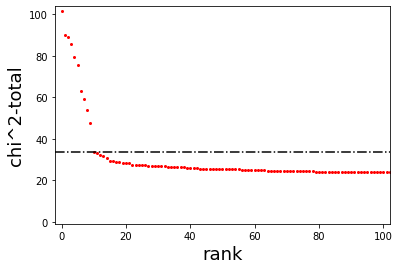

In [7]:
N = 5000
M = 1000000
H = np.zeros(M)
I = np.zeros(M)
J = np.zeros(M)

n = np.zeros((M,10))

for i in range(M-10):
    n[i][4] = np.random.binomial(2*N, 1/5)
    S = np.random.binomial(2*N-n[i][4], 1/4) #n7+n9+n10
    P = np.random.binomial(S, 1/2) #n7+n10
    n[i][6] = np.random.binomial(P, 1/2)
    n[i][9] = P - n[i][6]
    n[i][8] = S - P
    n[i][1] = np.random.binomial(2*N-n[i][4]-S, 1/3)
    T = np.random.binomial(2*N-n[i][4]-n[i][1]-S, 1/2) #n3+n4
    n[i][2] = np.random.binomial(T, 1/2)
    n[i][3] = T - n[i][2]
    R = 2*N-n[i][4]-n[i][1]-S-T
    Q = np.random.binomial(R, 1/2) #n6+n8
    n[i][5] = np.random.binomial(Q, 1/2)
    n[i][7] = Q - n[i][5]
    n[i][0] = R - Q
    
    H[i] = n[i][1]+n[i][2]+n[i][3] + 2*(n[i][4]+n[i][5]+n[i][6]+n[i][7]+n[i][8]+n[i][9])
    I[i] = n[i][3]+n[i][7]+n[i][8] + 2*n[i][9]
    J[i] = n[i][2]+n[i][5] + 2*n[i][6] + n[i][8]
    
for i in range(M-10,M):
    n[i][4] = np.random.binomial(2*N, 1.1/5)
    S = np.random.binomial(2*N-n[i][4], 1/4) #n7+n9+n10
    P = np.random.binomial(S, 1/2) #n7+n10
    n[i][6] = np.random.binomial(P, 1.1/2)
    n[i][9] = P - n[i][6]
    n[i][8] = S - P
    n[i][1] = np.random.binomial(2*N-n[i][4]-S, 1.1/3)
    T = np.random.binomial(2*N-n[i][4]-n[i][1]-S, 1/2) #n3+n4
    n[i][2] = np.random.binomial(T, 1.1/2)
    n[i][3] = T - n[i][2]
    R = 2*N-n[i][4]-n[i][1]-S-T
    Q = np.random.binomial(R, 1/2) #n6+n8
    n[i][5] = np.random.binomial(Q, 1.1/2)
    n[i][7] = Q - n[i][5]
    n[i][0] = R - Q
    
    H[i] = n[i][1]+n[i][2]+n[i][3] + 2*(n[i][4]+n[i][5]+n[i][6]+n[i][7]+n[i][8]+n[i][9])
    I[i] = n[i][3]+n[i][7]+n[i][8] + 2*n[i][9]
    J[i] = n[i][2]+n[i][5] + 2*n[i][6] + n[i][8]

stats = np.zeros(M)
order = np.zeros(M)

for i in range(M):
    order[i] = i
    if H[i] == 0:
        stats[i] = 0
    else:
        stats[i] = (2*((I[i]-J[i])**2))/H[i] + ((2*I[i] + 2*J[i] - H[i])**2)/H[i]

x = np.argsort(stats)
sorted_stats = sorted(stats, reverse=True)

fig = plt.figure()
plt.ylim(-1, max(stats)+2)
plt.xlim(-2, 102)
plt.plot(order, sorted_stats, marker="o", markersize=2, color = "red", linestyle = "None")
plt.axhline(33.6, color = "black", linestyle = "-.")
plt.xlabel("rank", fontsize = 18)
plt.ylabel("chi^2-total", fontsize = 18)
fig.savefig("stats-total.png")
fig.savefig("fig/stats-total.eps")

In [8]:
cc = 33.6
appx_shd = np.zeros(M)

for i in range(M):
    k = [int(n[i][0]), int(n[i][1]), int(n[i][2]), int(n[i][3]), int(n[i][4]), int(n[i][5]), int(n[i][6]), int(n[i][7]), int(n[i][8]), int(n[i][9])]
    appx_shd[i] = appx_SHD_total(cc,k)

print(appx_shd)

<ipython-input-4-93072744abec>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  theta[c] = math.asin(roots[i])


[-70. -80. -67. ...  38.  67.  70.]


In [9]:
def rankError_Lap(data,epsilon, K, N, M):
    RE = 0
    for j in range(50):
        noisy_stats = lap_noise(np.array(data), epsilon, K, N, M)
        noisy_rank = rankdata(-noisy_stats)
        #print(noisy_rank)
        for i in range(K):
            RE += (noisy_rank[i]-i)
    RE /= (K*50)
    return RE

In [10]:
def rankError_Exp(x, appx_shd, epsilon, K, N, M):
    RE = 0
    cc = 33.6
    
    #print(x)
        
    APPX = np.zeros(M)
        
    for j in range(50):
            
        for i in range(M):
            APPX[i] = appx_shd[i]
        
        #print(APPX)
        #print(SHD)
        
        appx_result = exp_mec(APPX, M, K, epsilon)
        
        for k in range(K):
            for l in range(M):
                if(appx_result[k] == x[M-1-l]):
                    RE += math.fabs(k-l)
                    break
    RE /= (K*50)
    return RE

In [11]:
K = 1
N = 5000
M = 1000000

RE = np.zeros((7,2))
sum_re = np.zeros((7,2))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        RE[i][0] = rankError_Lap(sorted_stats,epsilon[i],K,N,M)
        RE[i][1] = rankError_Exp(x,appx_shd,epsilon[i],K,N,M)
        sum_re[i] += RE[i]
    #print(RE)

RE = sum_re / 5
print(RE)

[[3.30463758e+05 3.44031460e+05]
 [5.22465260e+04 3.00000000e-01]
 [6.05641800e+03 1.60000000e-02]
 [1.00640000e+01 0.00000000e+00]
 [1.33200000e+00 0.00000000e+00]
 [1.14000000e+00 0.00000000e+00]
 [1.08000000e+00 0.00000000e+00]]


In [12]:
K = 2
N = 5000
M = 1000000

RE = np.zeros((7,2))
sum_re = np.zeros((7,2))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        RE[i][0] = rankError_Lap(sorted_stats,epsilon[i],K,N,M)
        RE[i][1] = rankError_Exp(x,appx_shd,epsilon[i],K,N,M)
        sum_re[i] += RE[i]
    #print(RE)

RE = sum_re / 5
print(RE)

[[4.21418564e+05 4.21836362e+05]
 [2.04181281e+05 9.98142000e+02]
 [6.14652640e+04 7.22000000e-01]
 [7.47761600e+03 3.00000000e-01]
 [2.22068000e+02 2.96000000e-01]
 [1.75680000e+01 2.86000000e-01]
 [2.94800000e+00 2.84000000e-01]]


In [13]:
K = 3
N = 5000
M = 1000000

RE = np.zeros((7,2))
sum_re = np.zeros((7,2))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        RE[i][0] = rankError_Lap(sorted_stats,epsilon[i],K,N,M)
        RE[i][1] = rankError_Exp(x,appx_shd,epsilon[i],K,N,M)
        sum_re[i] += RE[i]
    #print(RE)

RE = sum_re / 5
print(RE)

[[4.42557143e+05 4.49297747e+05]
 [2.96296476e+05 1.63564383e+05]
 [1.65125025e+05 9.22666667e-01]
 [3.58114413e+04 5.04000000e-01]
 [6.37248400e+03 4.61333333e-01]
 [7.92685333e+02 3.76000000e-01]
 [1.38708000e+02 3.62666667e-01]]


In [14]:
K = 5
N = 5000
M = 1000000

RE = np.zeros((7,2))
sum_re = np.zeros((7,2))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        RE[i][0] = rankError_Lap(sorted_stats,epsilon[i],K,N,M)
        RE[i][1] = rankError_Exp(x,appx_shd,epsilon[i],K,N,M)
        sum_re[i] += RE[i]
    #print(RE)

RE = sum_re / 5
print(RE)

[[4.76661090e+05 4.67798011e+05]
 [3.69819444e+05 3.35826498e+05]
 [2.63144783e+05 5.92644984e+04]
 [1.22233030e+05 8.68000000e-01]
 [5.27323556e+04 5.92800000e-01]
 [2.06275224e+04 4.05600000e-01]
 [7.76802320e+03 3.77600000e-01]]


In [15]:
K = 10
N = 5000
M = 1000000

RE = np.zeros((7,2))
sum_re = np.zeros((7,2))

epsilon = [0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]

for j in range(5):
    for i in range(7):
        RE[i][0] = rankError_Lap(sorted_stats,epsilon[i],K,N,M)
        RE[i][1] = rankError_Exp(x,appx_shd,epsilon[i],K,N,M)
        sum_re[i] += RE[i]
    #print(RE)

RE = sum_re / 5
print(RE)

[[4.76857447e+05 4.93776342e+05]
 [4.43843672e+05 4.30757477e+05]
 [3.89440053e+05 3.43777426e+05]
 [2.94703387e+05 8.39707188e+04]
 [2.16492107e+05 6.26981320e+03]
 [1.53766553e+05 1.93524000e+01]
 [1.21045393e+05 5.70000000e-01]]
